In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import time
import numpy as np
import tensorflow as tf
from VGG import VGG
import utils
import cv2
import matplotlib.pyplot as plt
tf.reset_default_graph()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
##############################
### setup hyper parameter
##############################
STYLE_LOSS_WEIGHT = 500
CONTENT_LOSS_WEIGHT = 5
LEARNING_RATE = 10
CONTENT_LAYERS = 'conv4_2'
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
STYLE_LAYERS_WEIGHTS = [0.5, 1.0, 1.5, 3.0, 4.0]
TRAINING_EPOCH = 500

<tf.Variable 'inputs/img_input:0' shape=(1, 300, 300, 3) dtype=float32_ref>
VGG-19 pre-trained model is ready
i am arrive


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 0: total_loss = 7569930715136.0


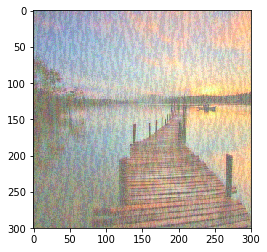

epoch 1: total_loss = 4900055941120.0
epoch 2: total_loss = 3496010842112.0
epoch 3: total_loss = 2316581994496.0
epoch 4: total_loss = 1887555813376.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 5: total_loss = 1753159041024.0


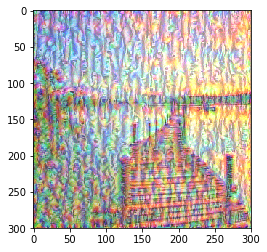

epoch 6: total_loss = 1728540049408.0
epoch 7: total_loss = 1554642108416.0
epoch 8: total_loss = 1322897113088.0
epoch 9: total_loss = 1122187083776.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 10: total_loss = 985751879680.0


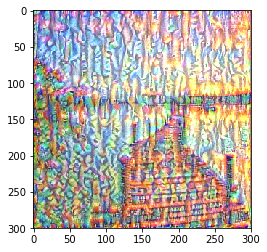

epoch 11: total_loss = 893396320256.0
epoch 12: total_loss = 805831573504.0
epoch 13: total_loss = 730550304768.0
epoch 14: total_loss = 674628304896.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 15: total_loss = 624865968128.0


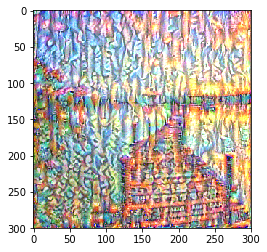

epoch 16: total_loss = 581741969408.0
epoch 17: total_loss = 548109680640.0


In [ ]:
class Style_Transfer(object):
    
    def __init__(self, 
                 content_img, 
                 style_img, 
                 img_width = 224, 
                 img_height = 224):
        
        self.content_img = cv2.imread(content_img)
        self.content_img = cv2.resize(self.content_img, (img_width, img_height))
        self.content_img = cv2.cvtColor(self.content_img, cv2.COLOR_BGR2RGB)
        self.content_img = self.content_img.reshape([1, img_width, img_height,3])
        self.content_img = np.asarray(self.content_img, np.float32)
        self.style_img = cv2.imread(style_img)
        self.style_img = cv2.resize(self.style_img, (img_width, img_height))
        self.style_img = cv2.cvtColor(self.style_img, cv2.COLOR_BGR2RGB)
        self.style_img = self.style_img.reshape([1, img_width, img_height, 3])
        self.style_img = np.asarray(self.style_img,np.float32)
        
        noise_img = np.random.uniform(-30,30, (1,img_width, img_height,3)).astype(np.float32)
        self.gen_img = self.content_img*0.5 + noise_img*0.5
        
        self.img_width = img_width
        self.img_height = img_height
        
        ### identify weight used for calculating total loss
        self.style_loss_weight = STYLE_LOSS_WEIGHT
        self.content_loss_weight = CONTENT_LOSS_WEIGHT
        
        ### identify layers that represent style and content
        self.content_layer = CONTENT_LAYERS
        self.style_layers = STYLE_LAYERS
        
        ### identify weight used for calculating style loss for each layer
        self.style_layers_weights = STYLE_LAYERS_WEIGHTS
        
        ### identify image inputs
        with tf.variable_scope('inputs', reuse=tf.AUTO_REUSE) as scope:
            self.img_input = tf.get_variable(name='img_input',
                                            shape=([1,self.img_width,self.img_height,3]),
                                            dtype=tf.float32,
                                            initializer=tf.zeros_initializer())
            print(self.img_input)
            
        
        self.learning_rate = LEARNING_RATE
        self.global_step = tf.Variable(0, trainable=False, name='global_step')
        self.training_epoch = TRAINING_EPOCH
    
    def load_VGG(self):
        
        self.vgg = VGG(self.img_input)
        #self.vgg.input_img = self.vgg.input_img - self.vgg.mean_pixels
        self.vgg.load()
        self.content_img -= self.vgg.mean_pixels
        self.style_img -= self.vgg.mean_pixels
        '''
        self.content_vgg = VGG(self.content_img_input)
        self.content_vgg.input_img = self.content_vgg.input_img - self.content_vgg.mean_pixels
        self.content_vgg.load()
        
        self.style_vgg = VGG(self.style_img_input)
        self.style_vgg.input_img = self.style_vgg.input_img - self.style_vgg.mean_pixels
        self.style_vgg.load()   
        '''
    
    def _calculate_content_loss(self, gen_layer, content_layer):
        self.content_loss = tf.reduce_sum(tf.square(gen_layer - content_layer))/(4*content_layer.size)
    
    def _calculate_gram_matrix(self, matrix, N, M):
        F = tf.reshape(matrix, (N,M))
        return tf.matmul(tf.transpose(F),F)
        
    def _calculate_style_loss(self, gen_layers, style_layers):
        
        ### get the number of layers
        length = len(gen_layers)
        
        total_style_loss = 0
        
        for i in range(length):
            ### calculate n by multiplying width and height of that layer 
            n = style_layers[i].shape[1] * style_layers[i].shape[2]
            ### m is the depth 
            m = style_layers[i].shape[3]
            
            ### calculate style loss for each layer
            factor = 1/(2*n*m)**2
            l = factor*((self._calculate_gram_matrix(gen_layers[i], n, m) - self._calculate_gram_matrix(style_layers[i], n, m))**2)
            l = tf.reduce_sum(l)
            ### accumulate style loss from each layer
            total_style_loss += l*self.style_layers_weights[i]
        
        self.style_loss = total_style_loss
        
    def calculate_loss(self):
        with tf.Session() as sess:
            sess.run(self.img_input.assign(self.content_img))
            content_layer = sess.run(getattr(self.vgg, self.content_layer))
            #content_layers = sess.run(content_layers)
        gen_content_layer = getattr(self.vgg, self.content_layer)
        self._calculate_content_loss(gen_content_layer, content_layer)
        
        with tf.Session() as sess:
            sess.run(self.img_input.assign(self.style_img))
            style_layers = sess.run([getattr(self.vgg, layer) for layer in self.style_layers])
            #style_layers = sess.run(style_layers)
        gen_style_layers = [getattr(self.vgg, layer) for layer in self.style_layers]
        self._calculate_style_loss(gen_style_layers, style_layers)
        
        self.total_loss = self.style_loss_weight * self.style_loss + self.content_loss_weight * self.content_loss 
    
    def optimize(self):
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.total_loss)
    
    def build(self):
        self.load_VGG()
        self.calculate_loss()
        self.optimize()
        
    def train(self):
        print('i am arrive')
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(self.img_input.assign(self.gen_img))
            initial_step = sess.run(self.global_step)
            start_time = time.time()
            for i in range(self.training_epoch):
                sess.run(self.optimizer)
                loss = sess.run(self.total_loss)
                print("epoch {}: total_loss = {}".format(i, loss))
                if i % 5 == 0:
                    x = sess.run(self.img_input) + self.vgg.mean_pixels
                    plt.imshow(np.uint(x[0]))
                    plt.show()
                    
if __name__ == '__main__':
    machine = Style_Transfer('content/content.jpg', 'content/style.jpg', 300, 300)
    machine.build()
    machine.train()